## Vehicle Detection



---
## Import

In [1]:
import os
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import pandas as pd

%matplotlib inline

print("import finished.")

import finished.


## Read images

In [9]:
def showimage(path, image):
    img = cv2.imread(os.path.join(path, str(image)))
    return img

def bgr2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def csvread(path):
    colNames = ['ImageName', 'xmin', 'ymin', 'xmax', 'ymax', 'occluded', 'class', 'attributes']
    df = pd.read_csv(filepath_or_buffer = path, names = colNames, sep = ',', header = None, engine = 'python')
    image = df['ImageName']
    xmin = df['xmin']
    ymin = df['ymin']
    xmax = df['xmax']
    ymax = df['ymax']
    occluded = df['occluded']
    labels = df['class']
    attributes = df['attributes']
    return image, xmin, ymin, xmax, ymax, occluded, labels, attributes

def labelmap(labels):
    labels_mapping = {label:idx for idx,label in enumerate(np.unique(labels))}
    label = labels.map(labels_mapping)
    print(labels_mapping)
    return label

def imgsep_labelcounter(image, labels, n):
    num = labels[labels == n].size
    img = image[labels == n].tolist()
    return img, num

#def draw_boxes(image, score, boxes, )


In [10]:
csv_path = './object-dataset/labels.csv'
image, xmin, ymin, xmax, ymax, occluded, labels, attributes = csvread(csv_path)
label = labelmap(labels)
bike_image, bike_num = imgsep_labelcounter(image, label, 0)
car_image, car_num = imgsep_labelcounter(image, label ,1)
pedestrian_image, pedestrian_num = imgsep_labelcounter(image, label, 2)
trafficLight_image, trafficLight_num = imgsep_labelcounter(image, label, 3)
truck_image, truck_num = imgsep_labelcounter(image, label, 4)

{'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4}


## Random plot images

In [4]:
print("Num of bike image: "+str(bike_num))
print("Num of car image: "+str(car_num))
print("Num of pedestrian image: "+str(pedestrian_num))
print("Num of traffic light image: "+str(trafficLight_num))
print("Num of truck image: "+str(truck_num))

Num of bike image: 1676
Num of car image: 60788
Num of pedestrian image: 9866
Num of traffic light image: 17253
Num of truck image: 3503


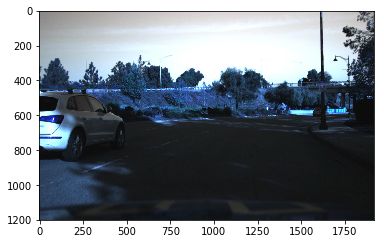

In [5]:
image_path = './object-dataset/'
ind = np.random.randint(0, len(car_image))
image = car_image[ind]
plt.imshow(showimage(image_path, image))

## HOG

Text(0.5,1,'HOG Visualization')

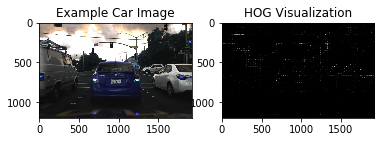

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_image))
# Read in the image
image = showimage(image_path, car_image[ind])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Combine and Normalize Features

In [19]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, path, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = showimage(path, file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_image, image_path, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
bike_features = extract_features(bike_image, image_path, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
pedestrain_features = extract_features(pedestrian_image, image_path, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
truck_features = extract_features(truck_image, image_path, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
trafficLight_features = extract_features(trafficLight_image, image_path, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, bike_features, pedestrain_features, truck_features, trafficLight_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.zeros(len(bike_features)), np.ones(len(car_features)), np.full(len(pedestrain_features), 2)))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

ValueError: all the input array dimensions except for the concatenation axis must match exactly